<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/Thyroid_nodule_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)
from zipfile import ZipFile


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

KeyboardInterrupt: ignored

In [ ]:
file_id = '1bbKAqUuk7Y1q3xsDSwP07oOXN_GL3SQM'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('COVID-SemiSegz')
with ZipFile('COVID-SemiSegz', 'r') as tt:
  tt.extractall("")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#su dung khi dataset o trong drive neu khong bo qua
%cp drive/My\ Drive/thyroid/crop_thyroid.zip /content/
with ZipFile('crop_thyroid.zip', 'r') as tt:
  tt.extractall("")

In [6]:
#su dung khi dataset o trong drive neu khong bo qua
%cp drive/My\ Drive/thyroid/training_data.zip /content/
with ZipFile('training_data.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [4]:
pip install elasticdeform

  Created wheel for elasticdeform: filename=elasticdeform-0.4.6-cp36-cp36m-linux_x86_64.whl size=70444 sha256=7379060a7ea26fed66be9090ba58dbd59b0a940f3a59c31c605567970bda3550
  Stored in directory: /root/.cache/pip/wheels/42/3a/94/a1d69f8b9da44826a171395e67f9f7a117f89af18f206481dd
Successfully built elasticdeform


In [5]:
import elasticdeform
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    img_mask = img_mask/255
    img_mask[img_mask<0.5] = 0
    img_mask[img_mask>=0.5] = 1
    return img_mask


def build_data(path,mask_folder,edge_folder, csv_path,img_shapes,training = True):
  w,h = img_shapes
  imgs=[]
  masks=[]
  edges = []
  img_name=[]
  if csv_path == None:
    img_name = os.listdir(path)
  else:
    with open(csv_path, 'r') as csvFile:
      reader = csv.reader(csvFile)
      for row in reader:
          img_name.append(row[0])
  n = len(img_name)//5
  for count,file in enumerate(img_name[:]):
        if file.find("super")>0:
          continue
        fullpath= os.path.join(path,file)
        #print(fullpath)
        msk=get_mask(file,mask_folder)
        if edge_folder is not None:
          edge = get_mask(file,edge_folder)
          edge=cv2.resize(edge,(w,h))
          edges.append(edge)
        #msk = msk[:, 50:-50]
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath,0)
        #image = image[:, 50:-50]
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%n == 0:
          plt.figure(count//n,figsize=(6,8),dpi=100)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          plt.contour(msk,colors='r')
          #plt.draw()
          plt.subplot(1,2,2).imshow(image, cmap = 'gray')
          plt.show() 
        if training:
            img2, mask2 = elasticdeform.deform_random_grid([image, msk], sigma=25, points=3)
            img3, mask3 = elasticdeform.deform_random_grid([image, msk], sigma=25, points=3)
            imgs.append(img2)
            masks.append(mask2)
            imgs.append(img3)
            masks.append(mask3)
  imgs=np.asarray(imgs,dtype=np.float).reshape(-1,h,w,1)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  edges=np.asarray(edges,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks,edges

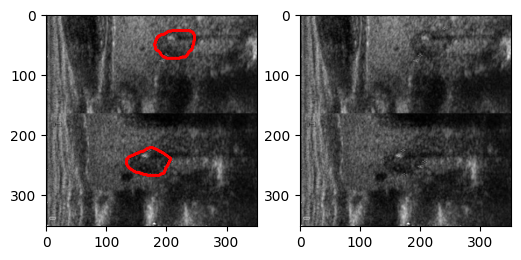

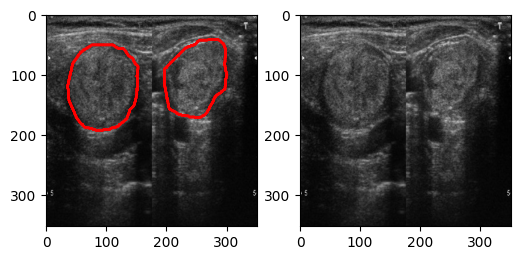

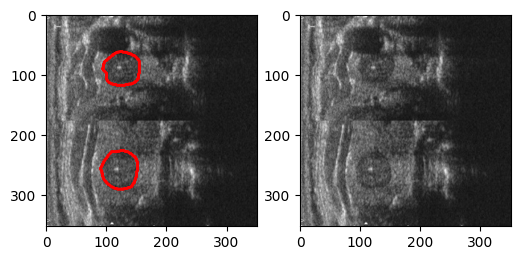

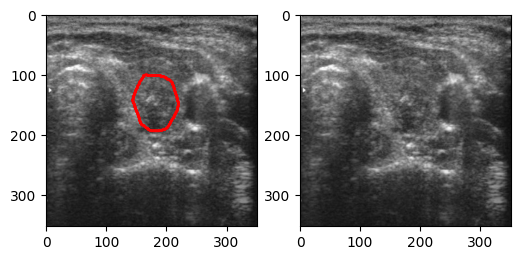

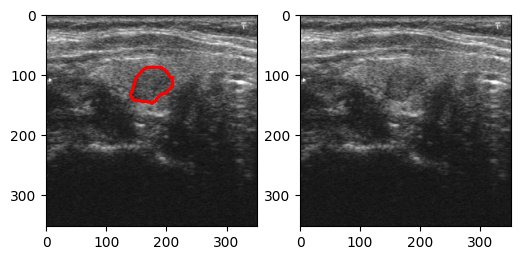

shape imgs:  (395, 352, 352, 1)
shape masks:  (395, 352, 352, 1)
---------------------------------------------------------


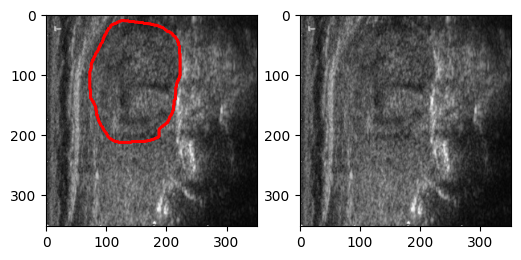

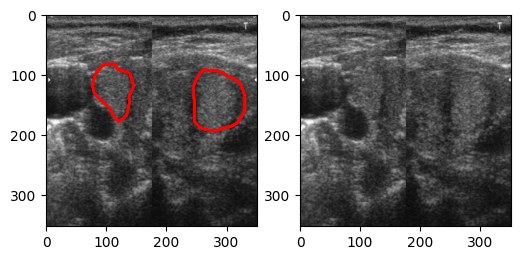

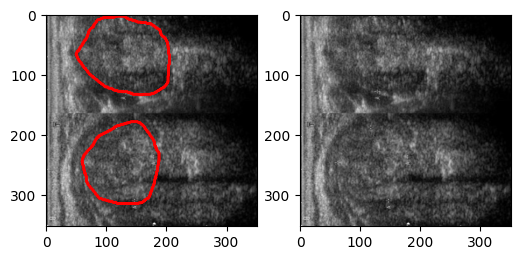

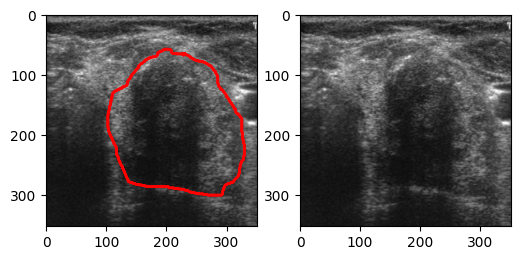

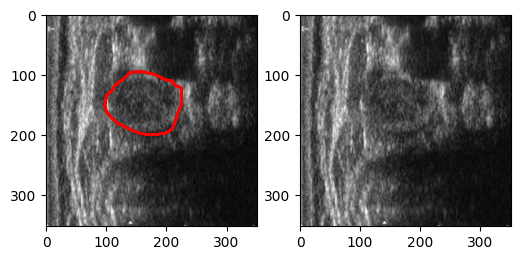

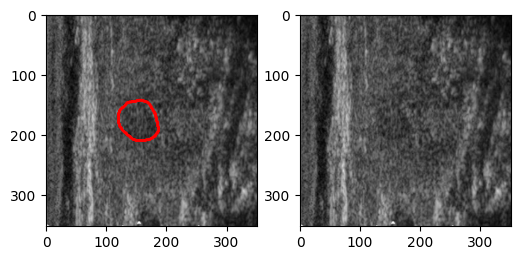

shape imgs:  (71, 352, 352, 1)
shape masks:  (71, 352, 352, 1)


In [6]:
w = 352
h = 352
folder_train = "/content/crop_train"
#folder_train = "/content/training_data/imgs"  # thay folder Doctor -> Pseudo để lấy 1600 ảnh pseudo train
mask_train_folder = "/content/crop_mask"
edge_train_folder = None

#mask_train_folder = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Pseudo-label/GT"
folder_test = "/content/crop_test"
mask_test_folder = "/content/crop_mask_test"
edge_dev_folder = None
imgs,masks,edge = build_data(folder_train,mask_train_folder,edge_train_folder, None, (w,h),training= False)
print("---------------------------------------------------------")
img_dev,mask_dev,edge_dev = build_data(folder_test,mask_test_folder,edge_dev_folder, None, (w,h),training=False)



#loss

In [7]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    #y_pred = heviside(y_pred,epsilon = 0.01)
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=1.0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_pred = y_pred[0]
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
def heviside(x,epsilon=0.1):
    return 1/2*(1+2/3.14159*tf.math.atan(x/epsilon))
def Active_Contour_Loss(y_true, y_pred): 
    epison = 0.1
    #Drc = (epison / 3.14159) / (epison * epison + y_pred[:,:,:,0] * y_pred[:,:,:,0])
    #Hea = 1/2*(1+2/3.14159*tf.math.atan(y_pred[:,:,:,0]/0.1))
    Hea = tf.sigmoid(y_pred[:,:,:,0])
    mean_in = np.ones((h, w))
    mean_out = np.zeros((h, w))

    region_in = K.abs(K.mean( Hea * ((y_true[:,:,:,0] - mean_in)**2) ) ) 
    region_out = K.abs(K.mean( (1-Hea) * ((y_true[:,:,:,0] - mean_out)**2) )) 
    #region_in + 2*region_out
    return  region_in + 2*region_out # 0.5*tf.keras.losses.binary_crossentropy(y_true[:,:,:,0],Hea)
def loss_edge(y_true, y_pred):
    epison = 1/3.14159
    Drc = epison / (3.14159 * (epison * epison + y_pred * y_pred))
    x = y_true[:,1:,:,:] - y_true[:,:-1,:,:] # horizontal and vertical directions 
    y = y_true[:,:,1:,:] - y_true[:,:,:-1,:]
    delta_x = x[:,1:,:-2,:]**2
    delta_y = y[:,:-2,1:,:]**2
    delta_u = K.sqrt(K.abs(delta_x + delta_y))/np.sqrt(2)
    return tf.keras.losses.binary_crossentropy(delta_u,Drc[:,1:-1,1:-1,:])

In [8]:
def tv_bce(y_true,y_pred):
    x = y_pred[:,1:,:,:] - y_pred[:,:-1,:,:]
    y = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:]
    sum = tf.reduce_sum(tf.abs(x))+tf.reduce_sum(tf.abs(y))
    return sum*1e-6+tf.keras.losses.binary_crossentropy(y_true,y_pred)


#attention gate

In [9]:
def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):

    #print(nb_filter)
    channel_axis = -1
    x = Conv2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias)(x)
    #x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Lambda(mvn)(x)
    x = Activation('relu')(x)
    return x
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    #attention_up_and_concate(conv6,skip2)
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    #up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)

    f =add([theta_x, phi_g])
    f = Activation("relu")(f)
    # branch_0 = conv2d_bn(f, inter_channel//4, 1, 1)

    # branch_1 = conv2d_bn(f, inter_channel//5, 1, 1)
    # branch_1 = conv2d_bn(branch_1, inter_channel//4, 3, 3)

    # branch_2 = conv2d_bn(f, inter_channel//5, 1, 1)
    # branch_2 = conv2d_bn(branch_2, inter_channel//4, 3, 3)
    # branch_2 = conv2d_bn(branch_2, inter_channel//4, 3, 3)

    # branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(f)
    # branch_3 = conv2d_bn(branch_3, inter_channel//4, 1, 1)

    # x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)
    #rate = Activation(heviside())(psi_f)
    att_x = multiply([x, rate])

    return att_x

#callback

In [10]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))


class visualize(tf.keras.callbacks.Callback):
    def __init__(self,img,mask):
        super(visualize, self).__init__()
        self.img = img
    def on_epoch_end(self, epoch, logs=None):
       feature_maps = self.model.predict(img)
       if len(feature_maps)==2:
          fm = feature_maps[0][0]
       else:
           fm = feature_maps[0]
       fmh = heviside(fm)
       #print(fm.shape)
       square = 2
       print("------------------------")
       #print(feature_maps[-1][0,:3,:3,0])
       print("-------------------------")
       #print(feature_maps[0][0,:3,:3,0])
       plt.subplot(132),plt.imshow(fmh[:,:,0],cmap = 'gray')
       plt.subplot(133),plt.imshow(fm[:,:,0],cmap = 'gray')
       plt.subplot(131),plt.imshow(mask[0,:,:,0],cmap = 'gray')
       plt.show()
      #  for fmap in feature_maps[1:]:
      #       ix = 1
      #       for _ in range(square):
      #           for _ in range(square):
      #               # specify subplot and turn of axis
      #               ax = plt.subplot(square, square, ix)
      #               ax.set_xticks([])
      #               ax.set_yticks([])
      #               # plot filter channel in grayscale
      #               if ix > fmap.shape[-1]:
      #                   continue
      #               plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      #               ix += 1
      #       plt.show()




#efficient Net

In [11]:
def efficient_unet(image_shape,num_class,weights=None):
  data = Input(shape=image_shape)
  mvn0 = Lambda(mvn)(data)
  conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
  conv1 = Lambda(mvn)(conv1)
  conv1 = Activation('relu')(conv1)
  conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
  conv1 = Lambda(mvn)(conv1)
  conv1 = Activation('relu')(conv1)
  base =  app.efficientnet.EfficientNetB4(include_top=False, weights=None, input_tensor= conv1)
  x=base.get_layer("top_activation").output #7x7x1280 chia 32
  skip1=base.get_layer("block6a_expand_activation").output 
  skip2 =base.get_layer("block4a_expand_activation").output 
  skip3 = base.get_layer("block3a_expand_activation").output 
  skip4 = base.get_layer("block2a_expand_activation").output 
  skip5 = base.layers[9].output 
  model = decode_unet(x,data,skip1,skip2,skip3,skip4,skip5)

  return model



In [12]:
def xcep_unet(image_shape,num_class,weights=None):
    data = Input(shape=image_shape)
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    base =  app.Xception(include_top=False, weights=None, input_tensor= conv1)
    x=base.get_layer("block14_sepconv2_act").output #chia 32
    skip1=base.get_layer("block13_sepconv2_bn").output #chia 16
    skip2 =base.get_layer("block4_sepconv2_bn").output  #chia 8
    skip3 = base.get_layer("block3_sepconv2_bn").output 
    skip3 = ZeroPadding2D(((0,1),(0,1)))(skip3)
    skip4 = base.get_layer("block2_sepconv2_bn").output
    skip4 = ZeroPadding2D(((1,2),(1,2)))(skip4)
    skip5 =conv1
    model = decode_unet(x, data, skip1,skip2,skip3,skip4,skip5)
    return model


In [13]:
def block_inception_a(input):
    inter_channel = input.get_shape().as_list()[3]
    branch_0 = conv2d_bn(input, inter_channel//4, 1, 1)

    branch_1 = conv2d_bn(input, inter_channel//5, 1, 1)
    branch_1 = conv2d_bn(branch_1, inter_channel//4, 3, 3)

    branch_2 = conv2d_bn(input, inter_channel//5, 1, 1)
    branch_2 = conv2d_bn(branch_2, inter_channel//4, 3, 3)
    branch_2 = conv2d_bn(branch_2, inter_channel//4, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, inter_channel//4, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=-1)
    return x
def incep_unet(image_shape,num_class,weights=None):
    data = Input(shape=image_shape)
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    base =  app.InceptionV3(include_top=False, weights=None, input_tensor= data)
    x=base.layers[-3].output #chia 32
    x = ZeroPadding2D(((0,1),(0,1)))(x)
    skip1=base.layers[228].output #chia 16
    skip2 =base.layers[86].output  #chia 8
    skip2 = Cropping2D(((0,1),(0,1)))(skip2)
    skip3 = base.layers[16].output 
    skip3 = Cropping2D(((2,2),(2,2)))(skip3)
    #skip3 = ZeroPadding2D(((0,1),(0,1)))(skip3)
    skip4 = base.layers[9].output
    #skip4 = ZeroPadding2D(((1,2),(1,2)))(skip4)
    skip5 = base.layers[1].output
    print("output: ",x.shape)
    print("skip1 shape: ",skip1.shape)
    print("skip2 shape: ",skip2.shape)
    print("skip3 shape: ",skip3.shape)
    print("skip4 shape: ",skip4.shape)
    print("skip5 shape: ",skip5.shape)
    model = decode_unet(x, data, skip1,skip2,skip3,skip4,skip5 = None)
    return model

In [14]:
def mobile_unet(image_shape,num_class,weights=None):
    data = Input(shape=image_shape)
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    base =  app.MobileNet(include_top=False, weights=None, input_tensor= conv1)
    x=base.layers[-7].output #chia 32
    #x = ZeroPadding2D(((0,1),(0,1)))(x)
    skip1=base.layers[73+7].output #chia 16
    skip2 =base.layers[36+7].output  #chia 8
    skip3 = base.layers[23+7].output #chia4
    skip4 = base.layers[10+7].output  #chia2
    skip5 = conv1
    print("output: ",x.shape)
    print("skip1 shape: ",skip1.shape)
    print("skip2 shape: ",skip2.shape)
    print("skip3 shape: ",skip3.shape)
    print("skip4 shape: ",skip4.shape)
    print("skip5 shape: ",skip5.shape)
    model = decode_unet(x, data, skip1,skip2,skip3,skip4,skip5)
    return model

In [15]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = block_inception_a(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = block_inception_a(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = block_inception_a(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = block_inception_a(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = block_inception_a(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)
    #pool5 = MaxPooling2D(pool_size=(2, 2))(drop5)

    # convx = Conv2D(1024, 3,  padding = 'same')(pool5)
    # convx = Lambda(mvn)(convx)
    # convx = Activation('relu')(convx)
    # convx = Conv2D(1024, 3,  padding = 'same')(convx)
    # convx = Lambda(mvn)(convx)
    # convx = Activation('relu')(convx)
    # dropx = Dropout(0.5)(convx)


    model = decode_unet(drop5,data,conv4,conv3,conv2,conv1,skip5 = None)

    return model

In [16]:
def decode_unet(x,data,skip1,skip2,skip3,skip4,skip5):
    if skip5 is not None:
        #filters = [1024,728,256,128,64]
        filters = [1024,512,256,128,64]
    else:
        filters = [512,256,128,64]
    merge6 = attention_up_and_concate(x,skip1)
    conv6 = Conv2D(filters[0], 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(filters[0], 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)


    
    merge7 = attention_up_and_concate(conv6,skip2)
    conv7 = Conv2D(filters[1], 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(filters[1], 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    
    merge8 = attention_up_and_concate(conv7,skip3)
    conv8 = Conv2D(filters[2], 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(filters[2], 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)


     
    merge9 = attention_up_and_concate(conv8,skip4)
    conv9 = Conv2D(filters[3], 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(filters[3], 3,  padding = 'same')(conv9)
    
    if skip5 is not None:
        conv9 = Lambda(mvn)(conv9)
        conv9 = Activation('relu')(conv9)
        merge10 = attention_up_and_concate(conv9,skip5)
        conv10 = Conv2D(filters[4], 3,  padding = 'same')(merge10)
        conv10 = Lambda(mvn)(conv10)
        conv10 = Activation('relu')(conv10)
        conv10 = Conv2D(filters[4], 3,  padding = 'same')(conv10)
        #conv10 = Activation('relu')(conv10)
        edge_out = Conv2D(1, 1,name = "output1")(conv10)
        conv10 = Lambda(mvn)(conv10)
        #conv10 = BatchNormalization()(conv10)
        conv10 = Activation('relu')(conv10)
        conv10 = Conv2D(2, 3,  padding = 'same')(conv10)
        conv10 = Activation('relu')(conv10)
        conv10 = Conv2D(1, 1,name = "main_output")(conv10)
        #out = tf.keras.layers.Activation("sigmoid",name = "main_output")(conv10)
        model = Model(inputs = data, outputs = [conv10,edge_out])
    else:
        #conv9 = Lambda(mvn)(conv9)
        #conv9 = Activation('relu')(conv9)
        #conv9 = UpSampling2D()(conv9)
        #conv9 = Conv2D(filters[3], 3,  padding = 'same')(conv9)
        conv9 = Lambda(mvn)(conv9)
        conv9 = Activation('relu')(conv9)
        conv9 = Conv2D(filters[3], 3,  padding = 'same')(conv9)
        edge_out = Conv2D(1, 1,name = "output1")(conv9)
        conv9 = Lambda(mvn)(conv9)
        conv9 = Activation('relu')(conv9)
        conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
        conv9 = Activation('relu')(conv9)
        conv10 = Conv2D(1, 1,padding = 'same')(conv9)
        #print("output shape:",conv10.shape)
        conv10 = tf.keras.layers.Activation("sigmoid",name = "main_output")(conv10)
        model = Model(inputs = data, outputs = [conv10])
    return model

In [17]:
from sklearn.model_selection import train_test_split
 #from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 1
#X_train, X_test, y_train, y_test = train_test_split(imgs, masks, test_size=0.1)
x_gen = generator_x.flow(X_train, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(y_train, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

NameError: ignored

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

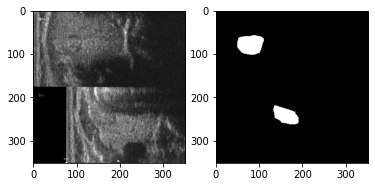

Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 0.6365 - dice_coef: 0.3631WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0083s vs `on_test_batch_end` time: 0.1364s). Check your callbacks.
------------------------
-------------------------


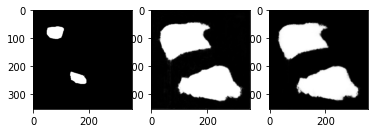


Epoch 00001: val_dice_coef improved from -inf to 0.50539, saving model to weights_save/ACLN.01_0.505.h5
99/99 [==============================] - 61s 617ms/step - loss: 0.6365 - dice_coef: 0.3631 - val_loss: 0.4950 - val_dice_coef: 0.5054
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 0.5167 - dice_coef: 0.4836------------------------
-------------------------


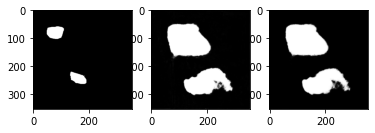


Epoch 00002: val_dice_coef improved from 0.50539 to 0.55156, saving model to weights_save/ACLN.02_0.552.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.5167 - dice_coef: 0.4836 - val_loss: 0.4486 - val_dice_coef: 0.5516
Epoch 3/100
99/99 [==============================] - ETA: 0s - loss: 0.4865 - dice_coef: 0.5129------------------------
-------------------------


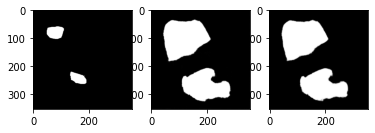


Epoch 00003: val_dice_coef did not improve from 0.55156
99/99 [==============================] - 56s 564ms/step - loss: 0.4865 - dice_coef: 0.5129 - val_loss: 0.4655 - val_dice_coef: 0.5351
Epoch 4/100
99/99 [==============================] - ETA: 0s - loss: 0.4660 - dice_coef: 0.5337------------------------
-------------------------


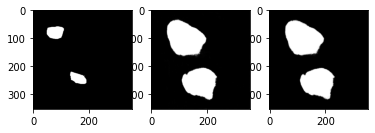


Epoch 00004: val_dice_coef improved from 0.55156 to 0.55558, saving model to weights_save/ACLN.04_0.556.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.4660 - dice_coef: 0.5337 - val_loss: 0.4447 - val_dice_coef: 0.5556
Epoch 5/100
99/99 [==============================] - ETA: 0s - loss: 0.4490 - dice_coef: 0.5511------------------------
-------------------------


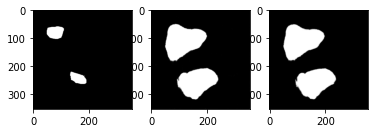


Epoch 00005: val_dice_coef improved from 0.55558 to 0.57921, saving model to weights_save/ACLN.05_0.579.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.4490 - dice_coef: 0.5511 - val_loss: 0.4207 - val_dice_coef: 0.5792
Epoch 6/100
99/99 [==============================] - ETA: 0s - loss: 0.4298 - dice_coef: 0.5704------------------------
-------------------------


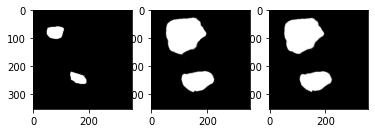


Epoch 00006: val_dice_coef improved from 0.57921 to 0.58772, saving model to weights_save/ACLN.06_0.588.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.4298 - dice_coef: 0.5704 - val_loss: 0.4120 - val_dice_coef: 0.5877
Epoch 7/100
99/99 [==============================] - ETA: 0s - loss: 0.4104 - dice_coef: 0.5898------------------------
-------------------------


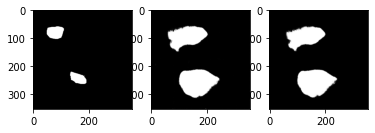


Epoch 00007: val_dice_coef improved from 0.58772 to 0.60142, saving model to weights_save/ACLN.07_0.601.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.4104 - dice_coef: 0.5898 - val_loss: 0.3975 - val_dice_coef: 0.6014
Epoch 8/100
99/99 [==============================] - ETA: 0s - loss: 0.3932 - dice_coef: 0.6068------------------------
-------------------------


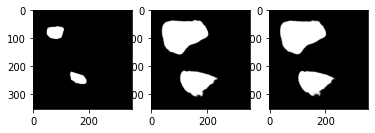


Epoch 00008: val_dice_coef improved from 0.60142 to 0.62000, saving model to weights_save/ACLN.08_0.620.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.3932 - dice_coef: 0.6068 - val_loss: 0.3793 - val_dice_coef: 0.6200
Epoch 9/100
99/99 [==============================] - ETA: 0s - loss: 0.3704 - dice_coef: 0.6296------------------------
-------------------------


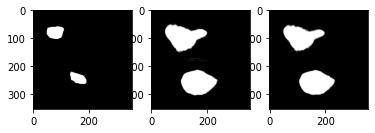


Epoch 00009: val_dice_coef did not improve from 0.62000
99/99 [==============================] - 56s 564ms/step - loss: 0.3704 - dice_coef: 0.6296 - val_loss: 0.3860 - val_dice_coef: 0.6129
Epoch 10/100
99/99 [==============================] - ETA: 0s - loss: 0.3619 - dice_coef: 0.6384------------------------
-------------------------


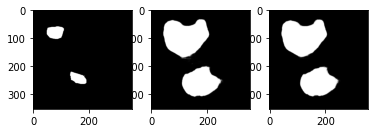


Epoch 00010: val_dice_coef did not improve from 0.62000
99/99 [==============================] - 56s 564ms/step - loss: 0.3619 - dice_coef: 0.6384 - val_loss: 0.3912 - val_dice_coef: 0.6086
Epoch 11/100
99/99 [==============================] - ETA: 0s - loss: 0.3447 - dice_coef: 0.6548------------------------
-------------------------


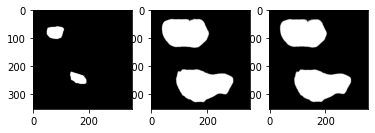


Epoch 00011: val_dice_coef improved from 0.62000 to 0.62154, saving model to weights_save/ACLN.11_0.622.h5
99/99 [==============================] - 56s 563ms/step - loss: 0.3447 - dice_coef: 0.6548 - val_loss: 0.3781 - val_dice_coef: 0.6215
Epoch 12/100
99/99 [==============================] - ETA: 0s - loss: 0.3271 - dice_coef: 0.6731------------------------
-------------------------


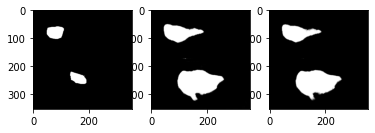


Epoch 00012: val_dice_coef did not improve from 0.62154
99/99 [==============================] - 56s 564ms/step - loss: 0.3271 - dice_coef: 0.6731 - val_loss: 0.3864 - val_dice_coef: 0.6127
Epoch 13/100
99/99 [==============================] - ETA: 0s - loss: 0.3162 - dice_coef: 0.6835------------------------
-------------------------


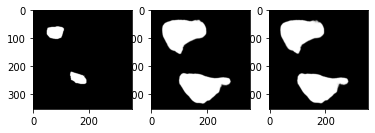


Epoch 00013: val_dice_coef improved from 0.62154 to 0.63463, saving model to weights_save/ACLN.13_0.635.h5
99/99 [==============================] - 56s 566ms/step - loss: 0.3162 - dice_coef: 0.6835 - val_loss: 0.3648 - val_dice_coef: 0.6346
Epoch 14/100
99/99 [==============================] - ETA: 0s - loss: 0.2778 - dice_coef: 0.7222------------------------
-------------------------


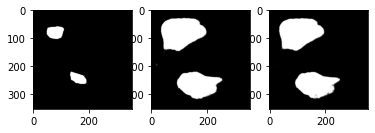


Epoch 00014: val_dice_coef improved from 0.63463 to 0.65894, saving model to weights_save/ACLN.14_0.659.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.2778 - dice_coef: 0.7222 - val_loss: 0.3398 - val_dice_coef: 0.6589
Epoch 15/100
99/99 [==============================] - ETA: 0s - loss: 0.2814 - dice_coef: 0.7186------------------------
-------------------------


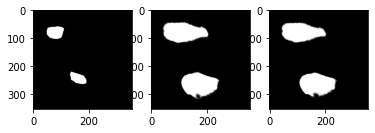


Epoch 00015: val_dice_coef did not improve from 0.65894
99/99 [==============================] - 56s 564ms/step - loss: 0.2814 - dice_coef: 0.7186 - val_loss: 0.3465 - val_dice_coef: 0.6517
Epoch 16/100
99/99 [==============================] - ETA: 0s - loss: 0.2545 - dice_coef: 0.7454------------------------
-------------------------


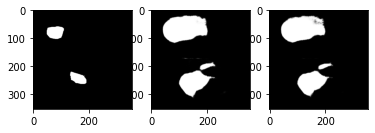


Epoch 00016: val_dice_coef did not improve from 0.65894
99/99 [==============================] - 56s 564ms/step - loss: 0.2545 - dice_coef: 0.7454 - val_loss: 0.3544 - val_dice_coef: 0.6439
Epoch 17/100
99/99 [==============================] - ETA: 0s - loss: 0.2467 - dice_coef: 0.7531------------------------
-------------------------


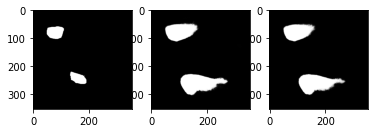


Epoch 00017: val_dice_coef did not improve from 0.65894
99/99 [==============================] - 56s 563ms/step - loss: 0.2467 - dice_coef: 0.7531 - val_loss: 0.3858 - val_dice_coef: 0.6124
Epoch 18/100
99/99 [==============================] - ETA: 0s - loss: 0.2327 - dice_coef: 0.7674------------------------
-------------------------


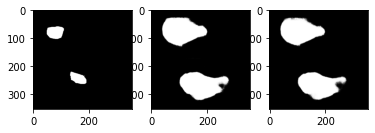


Epoch 00018: val_dice_coef improved from 0.65894 to 0.66726, saving model to weights_save/ACLN.18_0.667.h5
99/99 [==============================] - 56s 564ms/step - loss: 0.2327 - dice_coef: 0.7674 - val_loss: 0.3315 - val_dice_coef: 0.6673
Epoch 19/100
99/99 [==============================] - ETA: 0s - loss: 0.2073 - dice_coef: 0.7927------------------------
-------------------------


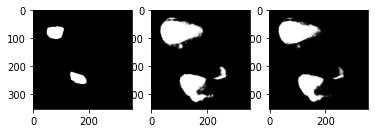


Epoch 00019: val_dice_coef improved from 0.66726 to 0.68724, saving model to weights_save/ACLN.19_0.687.h5
99/99 [==============================] - 56s 563ms/step - loss: 0.2073 - dice_coef: 0.7927 - val_loss: 0.3110 - val_dice_coef: 0.6872
Epoch 20/100
99/99 [==============================] - ETA: 0s - loss: 0.2035 - dice_coef: 0.7965------------------------
-------------------------


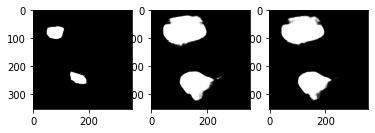


Epoch 00020: val_dice_coef did not improve from 0.68724
99/99 [==============================] - 56s 563ms/step - loss: 0.2035 - dice_coef: 0.7965 - val_loss: 0.3170 - val_dice_coef: 0.6812
Epoch 21/100
99/99 [==============================] - ETA: 0s - loss: 0.1799 - dice_coef: 0.8200------------------------
-------------------------


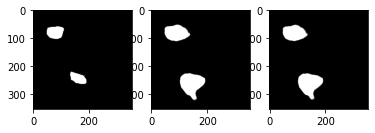


Epoch 00021: val_dice_coef did not improve from 0.68724
99/99 [==============================] - 56s 563ms/step - loss: 0.1799 - dice_coef: 0.8200 - val_loss: 0.3173 - val_dice_coef: 0.6807
Epoch 22/100
99/99 [==============================] - ETA: 0s - loss: 0.1606 - dice_coef: 0.8394------------------------
-------------------------


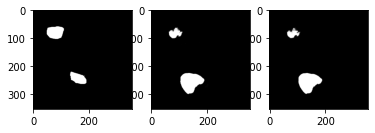


Epoch 00022: val_dice_coef did not improve from 0.68724
99/99 [==============================] - 56s 563ms/step - loss: 0.1606 - dice_coef: 0.8394 - val_loss: 0.3258 - val_dice_coef: 0.6721
Epoch 23/100
99/99 [==============================] - ETA: 0s - loss: 0.1429 - dice_coef: 0.8572------------------------
-------------------------


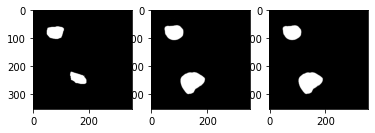


Epoch 00023: val_dice_coef improved from 0.68724 to 0.71216, saving model to weights_save/ACLN.23_0.712.h5
99/99 [==============================] - 56s 563ms/step - loss: 0.1429 - dice_coef: 0.8572 - val_loss: 0.2854 - val_dice_coef: 0.7122
Epoch 24/100
99/99 [==============================] - ETA: 0s - loss: 0.1266 - dice_coef: 0.8735------------------------
-------------------------


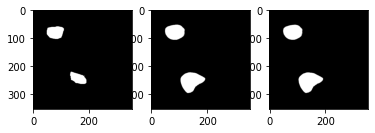


Epoch 00024: val_dice_coef did not improve from 0.71216
99/99 [==============================] - 56s 563ms/step - loss: 0.1266 - dice_coef: 0.8735 - val_loss: 0.3049 - val_dice_coef: 0.6933
Epoch 25/100
99/99 [==============================] - ETA: 0s - loss: 0.1164 - dice_coef: 0.8836------------------------
-------------------------


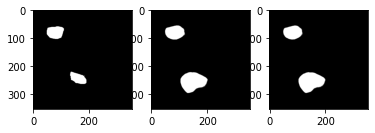


Epoch 00025: val_dice_coef did not improve from 0.71216
99/99 [==============================] - 56s 563ms/step - loss: 0.1164 - dice_coef: 0.8836 - val_loss: 0.3153 - val_dice_coef: 0.6835
Epoch 26/100
99/99 [==============================] - ETA: 0s - loss: 0.1118 - dice_coef: 0.8883------------------------
-------------------------


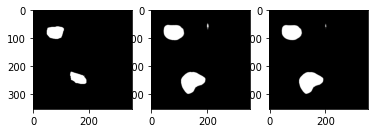


Epoch 00026: val_dice_coef improved from 0.71216 to 0.71622, saving model to weights_save/ACLN.26_0.716.h5
99/99 [==============================] - 56s 563ms/step - loss: 0.1118 - dice_coef: 0.8883 - val_loss: 0.2822 - val_dice_coef: 0.7162
Epoch 27/100
99/99 [==============================] - ETA: 0s - loss: 0.0955 - dice_coef: 0.9046------------------------
-------------------------


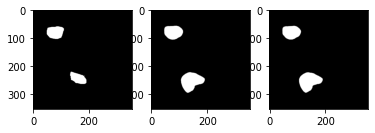


Epoch 00027: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0955 - dice_coef: 0.9046 - val_loss: 0.2944 - val_dice_coef: 0.7037
Epoch 28/100
99/99 [==============================] - ETA: 0s - loss: 0.0874 - dice_coef: 0.9127------------------------
-------------------------


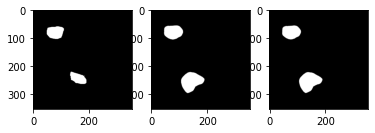


Epoch 00028: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0874 - dice_coef: 0.9127 - val_loss: 0.2921 - val_dice_coef: 0.7070
Epoch 29/100
99/99 [==============================] - ETA: 0s - loss: 0.0835 - dice_coef: 0.9165------------------------
-------------------------


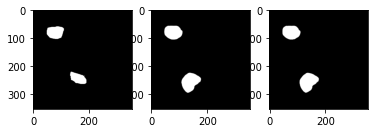


Epoch 00029: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0835 - dice_coef: 0.9165 - val_loss: 0.2914 - val_dice_coef: 0.7074
Epoch 30/100
99/99 [==============================] - ETA: 0s - loss: 0.0795 - dice_coef: 0.9205------------------------
-------------------------


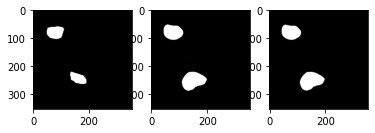


Epoch 00030: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 565ms/step - loss: 0.0795 - dice_coef: 0.9205 - val_loss: 0.2919 - val_dice_coef: 0.7069
Epoch 31/100
99/99 [==============================] - ETA: 0s - loss: 0.0800 - dice_coef: 0.9200------------------------
-------------------------


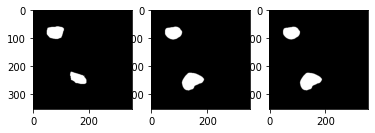


Epoch 00031: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0800 - dice_coef: 0.9200 - val_loss: 0.2870 - val_dice_coef: 0.7120
Epoch 32/100
99/99 [==============================] - ETA: 0s - loss: 0.0728 - dice_coef: 0.9269------------------------
-------------------------


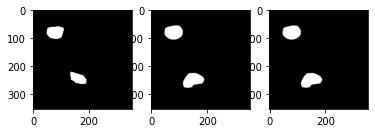


Epoch 00032: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0728 - dice_coef: 0.9269 - val_loss: 0.2915 - val_dice_coef: 0.7076
Epoch 33/100
99/99 [==============================] - ETA: 0s - loss: 0.0682 - dice_coef: 0.9318------------------------
-------------------------


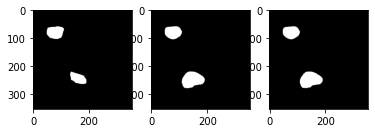


Epoch 00033: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0682 - dice_coef: 0.9318 - val_loss: 0.2921 - val_dice_coef: 0.7071
Epoch 34/100
99/99 [==============================] - ETA: 0s - loss: 0.0672 - dice_coef: 0.9328------------------------
-------------------------


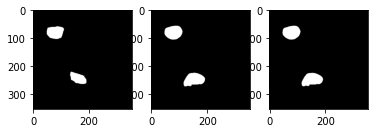


Epoch 00034: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0672 - dice_coef: 0.9328 - val_loss: 0.2943 - val_dice_coef: 0.7039
Epoch 35/100
99/99 [==============================] - ETA: 0s - loss: 0.0599 - dice_coef: 0.9401------------------------
-------------------------


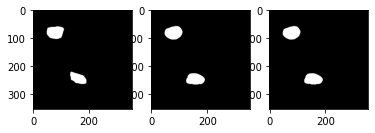


Epoch 00035: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0599 - dice_coef: 0.9401 - val_loss: 0.2860 - val_dice_coef: 0.7125
Epoch 36/100
99/99 [==============================] - ETA: 0s - loss: 0.0572 - dice_coef: 0.9428------------------------
-------------------------


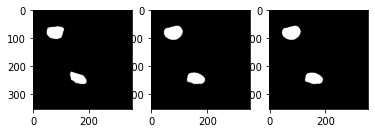


Epoch 00036: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0572 - dice_coef: 0.9428 - val_loss: 0.2905 - val_dice_coef: 0.7079
Epoch 37/100
99/99 [==============================] - ETA: 0s - loss: 0.0539 - dice_coef: 0.9461------------------------
-------------------------


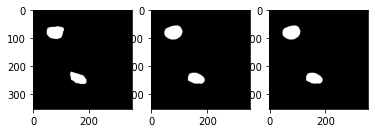


Epoch 00037: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0539 - dice_coef: 0.9461 - val_loss: 0.2868 - val_dice_coef: 0.7120
Epoch 38/100
99/99 [==============================] - ETA: 0s - loss: 0.0512 - dice_coef: 0.9488------------------------
-------------------------


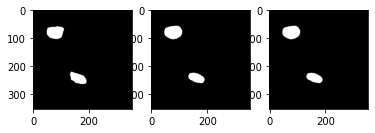


Epoch 00038: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0512 - dice_coef: 0.9488 - val_loss: 0.2847 - val_dice_coef: 0.7139
Epoch 39/100
99/99 [==============================] - ETA: 0s - loss: 0.0489 - dice_coef: 0.9511------------------------
-------------------------


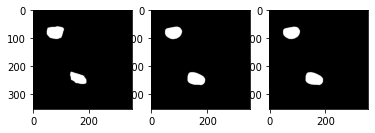


Epoch 00039: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0489 - dice_coef: 0.9511 - val_loss: 0.2893 - val_dice_coef: 0.7097
Epoch 40/100
99/99 [==============================] - ETA: 0s - loss: 0.0482 - dice_coef: 0.9516------------------------
-------------------------


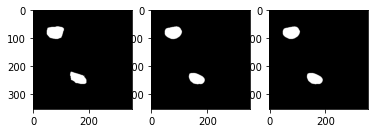


Epoch 00040: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0482 - dice_coef: 0.9516 - val_loss: 0.2854 - val_dice_coef: 0.7131
Epoch 41/100
99/99 [==============================] - ETA: 0s - loss: 0.0475 - dice_coef: 0.9525------------------------
-------------------------


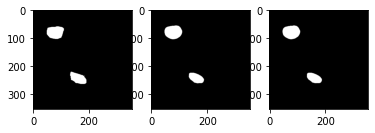


Epoch 00041: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0475 - dice_coef: 0.9525 - val_loss: 0.2877 - val_dice_coef: 0.7112
Epoch 42/100
99/99 [==============================] - ETA: 0s - loss: 0.0460 - dice_coef: 0.9540------------------------
-------------------------


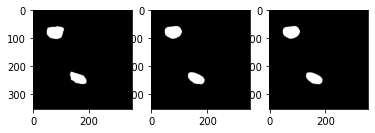


Epoch 00042: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0460 - dice_coef: 0.9540 - val_loss: 0.2900 - val_dice_coef: 0.7091
Epoch 43/100
99/99 [==============================] - ETA: 0s - loss: 0.0436 - dice_coef: 0.9565------------------------
-------------------------


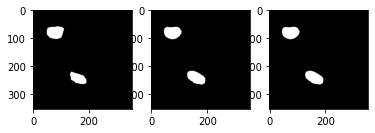


Epoch 00043: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0436 - dice_coef: 0.9565 - val_loss: 0.2860 - val_dice_coef: 0.7130
Epoch 44/100
99/99 [==============================] - ETA: 0s - loss: 0.0429 - dice_coef: 0.9572------------------------
-------------------------


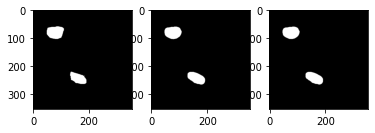


Epoch 00044: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0429 - dice_coef: 0.9572 - val_loss: 0.2905 - val_dice_coef: 0.7083
Epoch 45/100
99/99 [==============================] - ETA: 0s - loss: 0.0418 - dice_coef: 0.9582------------------------
-------------------------


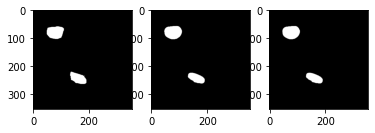


Epoch 00045: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 563ms/step - loss: 0.0418 - dice_coef: 0.9582 - val_loss: 0.2874 - val_dice_coef: 0.7112
Epoch 46/100
99/99 [==============================] - ETA: 0s - loss: 0.0423 - dice_coef: 0.9577------------------------
-------------------------


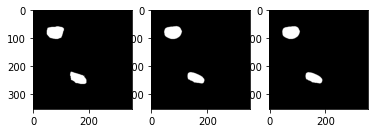


Epoch 00046: val_dice_coef did not improve from 0.71622
99/99 [==============================] - 56s 564ms/step - loss: 0.0423 - dice_coef: 0.9577 - val_loss: 0.2884 - val_dice_coef: 0.7102
Epoch 47/100
99/99 [==============================] - ETA: 0s - loss: 0.0408 - dice_coef: 0.9592------------------------
-------------------------


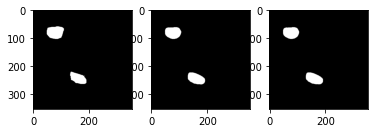


Epoch 00047: val_dice_coef improved from 0.71622 to 0.71751, saving model to weights_save/ACLN.47_0.718.h5
99/99 [==============================] - 56s 565ms/step - loss: 0.0408 - dice_coef: 0.9592 - val_loss: 0.2812 - val_dice_coef: 0.7175
Epoch 48/100
99/99 [==============================] - ETA: 0s - loss: 0.0396 - dice_coef: 0.9604------------------------
-------------------------


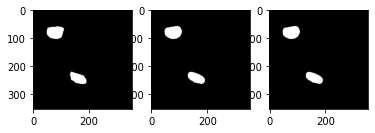


Epoch 00048: val_dice_coef did not improve from 0.71751
99/99 [==============================] - 56s 563ms/step - loss: 0.0396 - dice_coef: 0.9604 - val_loss: 0.2867 - val_dice_coef: 0.7123
Epoch 49/100
99/99 [==============================] - ETA: 0s - loss: 0.0385 - dice_coef: 0.9615------------------------
-------------------------


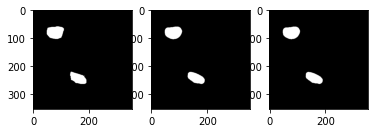


Epoch 00049: val_dice_coef did not improve from 0.71751
99/99 [==============================] - 56s 563ms/step - loss: 0.0385 - dice_coef: 0.9615 - val_loss: 0.2876 - val_dice_coef: 0.7117
Epoch 50/100
99/99 [==============================] - ETA: 0s - loss: 0.0370 - dice_coef: 0.9630------------------------
-------------------------


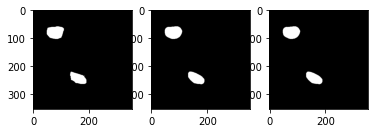


Epoch 00050: val_dice_coef did not improve from 0.71751
99/99 [==============================] - 56s 564ms/step - loss: 0.0370 - dice_coef: 0.9630 - val_loss: 0.2902 - val_dice_coef: 0.7087
Epoch 51/100
99/99 [==============================] - ETA: 0s - loss: 0.0365 - dice_coef: 0.9634------------------------
-------------------------


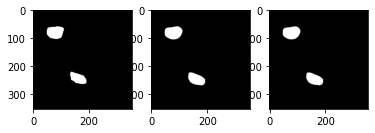


Epoch 00051: val_dice_coef did not improve from 0.71751
99/99 [==============================] - 56s 564ms/step - loss: 0.0365 - dice_coef: 0.9634 - val_loss: 0.2903 - val_dice_coef: 0.7088
Epoch 52/100
38/99 [==========>...................] - ETA: 32s - loss: 0.0375 - dice_coef: 0.9625

In [ ]:
input_shape = (h, w, 1)
img = imgs[6:7]
mask = masks[6:7]
plt.subplot(121),plt.imshow(img[0,:,:,0].astype("uint8"),cmap='gray')
plt.subplot(122),plt.imshow(mask[0,:,:,0].astype("uint8"),cmap='gray')
plt.show()
model = unet(input_shape,2)
#model.load_weights("/content/weights_save/ACLN.30_0.786.h5")
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = {"main_output":dice_coef_loss}, 
              #loss_weights={'main_output': 1., 'output1': 0.2},
              metrics = {"main_output":[dice_coef]})


checkpoint = ModelCheckpoint('weights_save/ACLN.{epoch:02d}_{val_dice_coef:.3f}.h5', 
                             monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
#lr_decay = lr_scheduler()
callback_list = [visualize(img,mask),checkpoint]
history = model.fit(imgs,masks,batch_size=4, epochs = 100, 
                    validation_data = (img_dev, mask_dev),
                    callbacks = callback_list,verbose = 1)

In [ ]:
img = imgs[6:7]
mask = masks[6:7]
plt.subplot(121),plt.imshow(img[0,:,:,0].astype("uint8"),cmap='gray')
plt.subplot(122),plt.imshow(mask[0,:,:,0].astype("uint8"),cmap='gray')
plt.show()

In [ ]:
print(max(history.history['val_main_output_dice_coef']))

Ket qua
Dung ham heviside active contour loss tỉ lệ 1 -2 

Fine tune từ tập pseudo

loss: 0.0579 - accuracy: 0.9366 - dice_coef: 0.8038 - val_loss: 0.0918 - val_accuracy: 0.9235 - val_dice_coef: 0.7649



chạy từ đầu ảnh doctor 80 epoch step  = 100/epoch

loss: 0.0482 - accuracy: 0.9437 - dice_coef: 0.8340 - val_loss: 0.1061 - val_accuracy: 0.9329 - val_dice_coef: 0.7451


chạy từ đầu ảnh pseudo 400step/epoch


loss: 0.0359 - accuracy: 0.9481 - dice_coef: 0.8590 - val_loss: 0.1045 - val_accuracy: 0.9298 - val_dice_coef: 0.7416

#visualize 

In [ ]:
val_main_output_dice_coefmodel = unet((352,352,3),2,"/content/drive/My Drive/weight_infection_acl/unet.23_0.72.h5")
mask_pred = model.predict(imgs)
mask_copy = mask_pred.copy()
mask_pred = heviside(mask_pred,0.01)
#mask_pred[mask_pred<0] = 0
#mask_pred[mask_pred>0] = 1

In [ ]:
plt.imshow(mask_pred[1,:,:,0],cmap= 'gray')
plt.show()    
plt.imshow(masks[1,:,:,0],cmap= 'gray')
plt.show()

In [ ]:
epison = 1/3.14159
Drc = epison / (3.14159 * (epison * epison + mask_copy[:,:,:,:] * mask_copy[:,:,:,:]))
print(K.mean(tf.keras.losses.binary_crossentropy(edge,Drc)))
plt.imshow(Drc[1,:,:,0],cmap= 'gray')
plt.xticks(np.arange(0, 353, 50))
plt.show()   
plt.imshow(edge[1,:,:,0],cmap= 'gray')
plt.show()
print(edge[1,:,:,0].max())

In [ ]:
x = masks[:,1:,:,:] - masks[:,:-1,:,:] # horizontal and vertical directions 
y = masks[:,:,1:,:] - masks[:,:,:-1,:]


delta_x = x[:,1:,:-2,:]**2
delta_y = y[:,:-2,1:,:]**2
delta_u = K.sqrt(K.abs(delta_x + delta_y))/np.sqrt(2)
print(delta_u.numpy().max())

plt.imshow(delta_u[1,:,:,0],cmap= 'gray')
plt.show()
plt.imshow(edge[1,:,:,0],cmap= 'gray')
plt.show()

In [ ]:
def dice_coef2(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss2(y_true, y_pred):
    return 1-dice_coef2(y_true, y_pred)

In [ ]:
model.load_weights("/content/drive/My Drive/weight_infection_acl/unet.55_0.74.h5")
mask_pred = model.predict(img_dev)
#mask_pred = heviside(mask_pred,epsilon=0.01)
mask_pred[mask_pred<0] = 0
mask_pred[mask_pred>0] = 1
print(dice_coef2(mask_dev,mask_pred))
plt.imshow(mask_pred[1,:,:,0],cmap= 'gray')
plt.show()    
plt.imshow(mask_dev[1,:,:,0],cmap= 'gray')
plt.show()

In [ ]:
import tensorflow.keras.applications as app
model = app.MobileNet()
for count,layer in enumerate(model.layers):
	# check for convolutional layer
	#if 'conv' not in layer.name:
	#	continue
	# get filter weights
	print(count, layer.name)
	#filters, biases = layer.get_weights()


In [ ]:
ixs = [2, 5, 9, 91, 94,97]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
pyplot.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
pyplot.show()
feature_maps = model.predict(imgs[:1,:,:,:])
# plot the output from each block
square = 2
for fmap in feature_maps:
    print(fmap.shape)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            if ix > fmap.shape[-1]:
                continue
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
	# show the figure
    pyplot.show()

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
